# <center>Финальное задание модуля EDA-5</center> #

## <center>**Анализ результатов A/B-тестирования**</center> ##

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

Более подробное описание задания приведено в файле [README.md](README.md)

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

# Для корректной работы Jupyter Notebook
%matplotlib inline
# Для корректного отображения графиков в тёмной теме
plt.style.use('default')

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [86]:
data = pd.read_csv('ab_data_tourist.csv')
display(data.head())

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [87]:
display(data.info())
print(f"Точнее тип данных в признаке 'date' - {type(data['date'][0])}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


None

Точнее тип данных в признаке 'date' - <class 'str'>


***Выводы***

Изначально признак **date** типа `object`, а точнее&nbsp;&mdash; `str`

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [88]:
data['date'] = pd.to_datetime(data['date'], yearfirst=True)
data_a = data[data['group'] == 'A']
data_b = data[data['group'] == 'B']

In [89]:
print(f"Начало тестирования группы A: {data_a['date'].min()}")
print(f"Начало тестирования группы B: {data_b['date'].min()}")
print(f"Конеу тестирования группы A: {data_a['date'].max()}")
print(f"Конеу тестирования группы B: {data_b['date'].max()}")

Начало тестирования группы A: 2021-01-02 00:00:00
Начало тестирования группы B: 2021-01-02 00:00:00
Конеу тестирования группы A: 2021-01-24 00:00:00
Конеу тестирования группы B: 2021-01-24 00:00:00


***Выводы***

Группы тестировались одновременно, в одном интервале времени с 02-01-2021 по 23-01-2021.

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [90]:
print('Всего посещений по группам:')
display(data['group'].value_counts(ascending=True))

print(f"\nСуммарное количество покупок в группе A: {data_a['purchase'].sum()}")
print(f"Суммарное количество покупок в группе B: {data_b['purchase'].sum()}\n")

print(f"Сумма всех покупок в группе A: {data_a['price'].sum() / 1_000_000} млн. руб.")
print(f"Сумма всех покупок в группе B: {data_b['price'].sum() / 1_000_000} млн. руб.")

Всего посещений по группам:


A    147202
B    147276
Name: group, dtype: int64


Суммарное количество покупок в группе A: 17723
Суммарное количество покупок в группе B: 17514

Сумма всех покупок в группе A: 1436.26 млн. руб.
Сумма всех покупок в группе B: 1554.1 млн. руб.


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [91]:
a_id_set = set(data_a['user_id'].values)
b_id_set = set(data_b['user_id'].values)
user_intersection = a_id_set.intersection(b_id_set)
print(f"{len(user_intersection)} пользователей попали в обе группы")

1895 пользователей попали в обе группы


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [92]:
data_clear = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

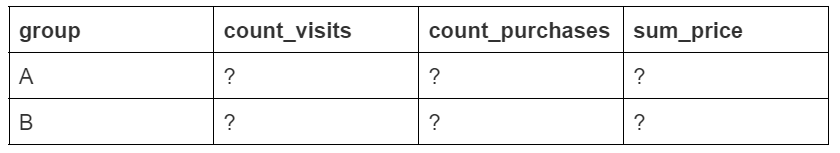
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [93]:
data_grp = data_clear.groupby(['group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})
display(data_grp)

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

***Выводы***

Количество посещений обоих вариантов посадочной страницы примерно равно. Выборки можно считать сбалансированными.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [94]:
data_grp['conversion'] = data_grp['count_purchases'] / data_grp['count_visits'] * 100
data_grp['mean_check'] = data_grp['sum_price'] / data_grp['count_purchases']
display(data_grp)
print(f"Конверсия в группе A: {round(data_grp['conversion']['A'], 2)}%")
print(f"Конверсия в группе B: {round(data_grp['conversion']['B'], 2)}%")
print(f"Средний чек в группе A: {round(data_grp['mean_check']['A'])} руб.")
print(f"Средний чек в группе B: {round(data_grp['mean_check']['B'])} руб.")

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


Конверсия в группе A: 12.03%
Конверсия в группе B: 11.89%
Средний чек в группе A: 81076 руб.
Средний чек в группе B: 88665 руб.


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

***Выводы***

Пока группа **A** показывает малозначительную эффективность по конверсии, но группа **B** эффективнее по среднему чеку, и существенно.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [95]:
''' Таблица, содержащая только строки с покупками (конверсией) '''
data_conv = data_clear[data_clear['purchase'] == 1]

data_piv = data_conv.pivot_table(
    values='purchase',
    index='group',
    columns=['price'],
    aggfunc='sum'
)
display(data_piv)

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

In [96]:
print(f"Количество проданных туров за 60000 рублей в группе A: {data_piv[60000].loc['A']}")
print(f"Количество проданных туров за 60000 рублей в группе B: {data_piv[60000].loc['B']}")

Количество проданных туров за 60000 рублей в группе A: 5271
Количество проданных туров за 60000 рублей в группе B: 1730


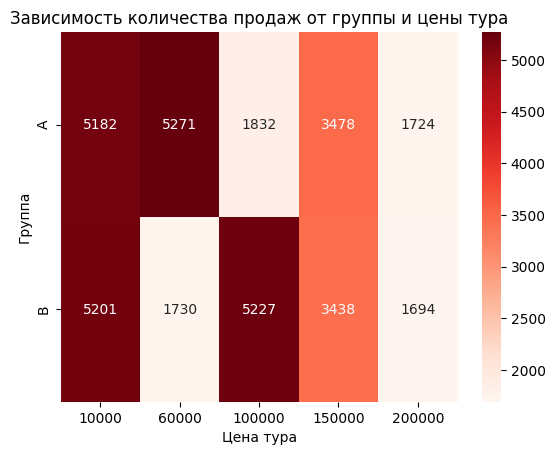

In [97]:
heatmap = sns.heatmap(data=data_piv, annot=True, fmt='d', cmap='Reds')
heatmap.set_title('Зависимость количества продаж от группы и цены тура')
heatmap.set_xlabel('Цена тура')
heatmap.set_ylabel('Группа');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

***Выводы***

Если конверсия по турам `"Санкт-Петербург"` (10000), `"Камчатка"` (150000), `"Мальдивы"` (200000) примерно одинакова по группам, то в турах `"Турция"` (60000) и `"Тайланд"` (100000) наблюдаются обратные соотношения&nbsp;&mdash; в группе **A** больше "Турции", а в группе **B** больше "Тайланда", причём почти в однинаковой пропорции, что, видимо, и повлияло на повышенный средний чек в группе **B**.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [98]:
data_daily = data_clear.groupby(['date', 'group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'sum_purchases',
    'price': 'sum_price'
})
data_daily['conversion'] = data_daily['sum_purchases'] / data_daily['count_visits'] * 100
data_daily['mean_check'] = data_daily['sum_price'] / data_daily['sum_purchases']
display(data_daily.head(4))

print(
    'Конверсия на 03-01-2021 в группе A: ',
    round(data_daily[data_daily['date'] == '2021-01-03'].loc[data_daily['group'] == 'A']['conversion'].values[0], 2),
    '%'
)
print(
    'Конверсия на 03-01-2021 в группе B: ',
    round(data_daily[data_daily['date'] == '2021-01-03'].loc[data_daily['group'] == 'B']['conversion'].values[0], 2),
    '%'
)
print(
    'Средний чек на 03-01-2021 в группе A: ',
    round(data_daily[data_daily['date'] == '2021-01-03'].loc[data_daily['group'] == 'A']['mean_check'].values[0])
)
print(
    'Средний чек на 03-01-2021 в группе B: ',
    round(data_daily[data_daily['date'] == '2021-01-03'].loc[data_daily['group'] == 'B']['mean_check'].values[0])
)


,date,group,count_visits,sum_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101


Конверсия на 03-01-2021 в группе A:  11.34 %
Конверсия на 03-01-2021 в группе B:  11.39 %
Средний чек на 03-01-2021 в группе A:  82888
Средний чек на 03-01-2021 в группе B:  87480


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [99]:
data_daily['cum_visits'] = data_daily.groupby(['group'])['count_visits'].cumsum()
data_daily['cum_purchases'] = data_daily.groupby(['group'])['sum_purchases'].cumsum()
data_daily['cum_price'] = data_daily.groupby(['group'])['sum_price'].cumsum()
data_daily['cum_conversion'] = data_daily['cum_purchases'] / data_daily['cum_visits'] * 100
data_daily['cum_mean_check'] = data_daily['cum_price'] / data_daily['cum_purchases']
display(data_daily.head(4))

data_daily_a = data_daily[data_daily['group'] == 'A']
data_daily_b = data_daily[data_daily['group'] == 'B']

print(
    'Кумулятивная конверсия на 20-01-2021 в группе B:',
    round(data_daily_b[data_daily_b['date'] == '2021-01-20']['cum_conversion'].values[0], 2),
    '%'
)
print(
    'Кумулятивный средний чек на 12-01-2021 в группе A:',
    round(data_daily_a[data_daily_a['date'] == '2021-01-12']['cum_mean_check'].values[0]),
    'руб.'
)

,date,group,count_visits,sum_purchases,sum_price,conversion,mean_check,cum_visits,cum_purchases,cum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427


Кумулятивная конверсия на 20-01-2021 в группе B: 11.9 %
Кумулятивный средний чек на 12-01-2021 в группе A: 81492 руб.


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

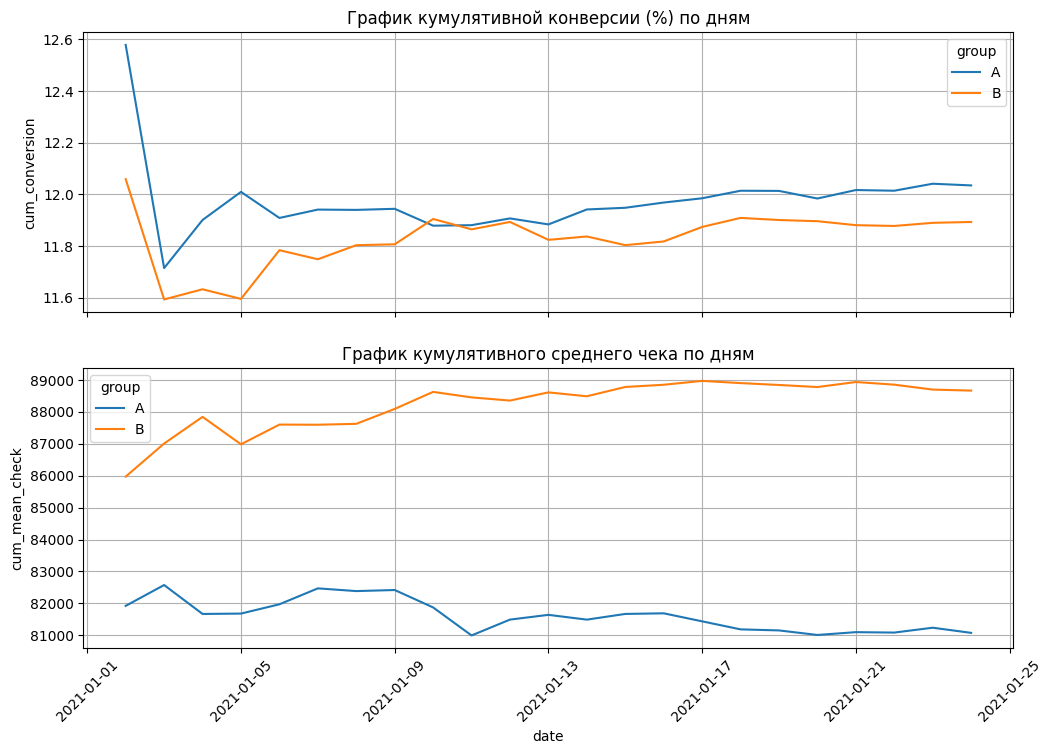

In [100]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)
sns.lineplot(
    data=data_daily,
    x='date',
    y='cum_conversion',
    hue='group',
    ax=ax[0]
)
sns.lineplot(
    data=data_daily,
    x='date',
    y='cum_mean_check',
    hue='group',
    ax=ax[1]
)
ax[0].set_title('График кумулятивной конверсии (%) по дням')
ax[0].grid(True)
ax[1].set_title('График кумулятивного среднего чека по дням')
ax[1].grid(True)
ax[1].xaxis.set_tick_params(rotation=45)

***Выводы***

- A/B-тестирование можно считать завершённым&nbsp;&mdash; значения метрик стабилизировались к концу теста.
- Кумулятивная конверсия в группе A стабилизировалась выше кумулятивной конверсии группы B.
- Кумулятивный средний чек в группе A стабилизирован ниже кумулятивного среднего чека группы B.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [101]:
display(data_clear.head(6))

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
5,936923,2021-01-10,A,0,0


In [102]:
data_conversions = data_clear.groupby('group')['purchase'].agg(['sum', 'count'])
display(data_conversions)

H0 = 'Конверсии в группах A и B равны'
H1 = 'Конверсия в группе A больше, чем конверсия в группе B'
alpha = 0.05

stat, p_alue = proportions_ztest(
    count=data_conversions['sum'],
    nobs=data_conversions['count'],
    alternative='larger'
)
print('p_value =', round(p_alue, 3))
if p_alue < alpha:
    print(f'Отвергается нулевая гипотеза ({H0})')
    print(f'Принимается альтернативная гипотеза ({H1})')
else:
    print(f'Подтверждается нулевая гипотеза ({H0})')

,sum,count
group,,
A,17487,145307
B,17290,145381


p_value = 0.12
Подтверждается нулевая гипотеза (Конверсии в группах A и B равны)


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

***Выводы***

По результатам **Z-теста** можно сделать вывод, что статистически значимой разницы между конверсиями в группах **А** и **B** не обнаружено.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [103]:
def conversions_conf_interval(n, X_p, gamma=0.95):
    ''' Расчитывает двусторонний доверительный интервал конверсии в группе
    Arguments:
        n [int] -- размер выборки
        X_p [float] -- средняя конверсия в выборке
        gamma [float] -- уровень надёжности [default=0.95]
    Returns:
        [tuple] -- кортеж из нижней и верхней границ
            двустороннего доверительного интервала
            в процентах с огруглением до сотых.
    '''
    alpha = 1 - gamma
    z_crit = -norm.ppf(alpha / 2)
    eps = z_crit * (X_p * (1 - X_p) / n) ** 0.5
    lower_bound = X_p - eps
    upper_bound = X_p + eps
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


def diff_conversions_conf_interval(n, X_p, gamma=0.95):
    ''' Расчитывает доверительный интервал разницы конверсии между группами
    Arguments:
        n [list] -- список размеров выборок по группам A и B соответственно
        X_p [list] -- список из средних конверсий в выборках групп A и B соответственно
        gamma [float] -- уровень надёжности [default=0.95]
    Returns:
        [tuple] -- кортеж из нижней и верхней границ
            доверительного интервала разницы конверсий
            в процентах с огруглением до сотых.
    '''
    alpha = 1 - gamma
    diff = X_p[1] - X_p[0]
    z_crit = -norm.ppf(alpha / 2)
    eps = z_crit * (X_p[0] * (1-X_p[0]) / n[0] + X_p[1] * (1-X_p[1]) / n[1]) ** 0.5
    lower_bound = diff - eps
    upper_bound = diff + eps
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


# Отдельные датасеты по группам
data_clear_a = data_clear[data_clear['group'] == 'A']
data_clear_b = data_clear[data_clear['group'] == 'B']


# Расчёт двусторонних доверительных интервалов конверсии по группам
conf_interval_a = conversions_conf_interval(
    n=data_clear_a['user_id'].count(),
    X_p=data_clear_a['purchase'].mean()
)
conf_interval_b = conversions_conf_interval(
    n=data_clear_b['user_id'].count(),
    X_p=data_clear_b['purchase'].mean()
)
print(f'Доверительный интервал для конверсии группы A: {conf_interval_a}')
print(f'Доверительный интервал для конверсии группы B: {conf_interval_b}')


# Расчёт доверительного интервала разницы конверсии между группами
n_list = [data_clear_a['user_id'].count(), data_clear_b['user_id'].count()]
Xp_list = [data_clear_a['purchase'].mean(), data_clear_b['purchase'].mean()]
diff_interval = diff_conversions_conf_interval(n_list, Xp_list)
print(f'Доверительный интервал для разности конверсий: {diff_interval}')

Доверительный интервал для конверсии группы A: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

***Выводы***

1. Есть перекрытие между доверительными интервалами конверсии для данных групп.
2. Левая граница доверительного интервала отрицательная, а правая&nbsp;&mdash; положительная.

Это означает, что нет статистически значимой разницы в конверсии групп **А** и **B**, и эти группы равнозначны по метрике конверсии.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [104]:
H0 = 'распределение нормальное'
H1 = 'распределение отлично от нормального '
alpha = 0.05

# Используется тест Шапиро-Уилка
stata, pa = shapiro(data_daily_a['mean_check'])
statb, pb = shapiro(data_daily_b['mean_check'])
print(f'p-value группы A: {round(pa, 3)}')
print(f'p-value группы B: {round(pb, 3)}')
if pa > alpha:
    print(f'Для группы A {H0}')
else:
    print(f'Для группы A {H1}')
if pb > alpha:
    print(f'Для группы B {H0}')
else:
    print(f'Для группы B {H1}')

p-value группы A: 0.253
p-value группы B: 0.094
Для группы A распределение нормальное
Для группы B распределение нормальное


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [105]:
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05

# Используется T-тест
stats, pt = ttest_ind(
    data_daily_a['mean_check'],
    data_daily_b['mean_check'],
    alternative='less'
)
print(f'p-value: {pt}')
if pt > alpha:
    print(f'Принимается нулевая гипотеза ({H0})')
else:
    print(f'Принимается альтернативная гипотеза ({H1})')

p-value: 1.1261794674808954e-12
Принимается альтернативная гипотеза (Ежедневный средний чек в группе А меньше чем в группе B)


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

***Выводы***

Между ежедневными средними чеками в группах А и B есть статистически значимая разница, что замечено на графике из **Задания 7.9** (стабилизация кумулятивных средних чеков со временем). Применение T-теста подтвердило альтернативную гипотезу о том, что ежедневный средний чек в группе **А** меньше, чем в группе **B**.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [106]:
def calc_conf_int_std(n, X_mean, X_std, gamma=0.95):
    ''' Расчитывает доверительный интервал при выборочном станлартном отклонении
    Arguments:
        n [int] -- размер выборки
        X_mean [float] -- среднее значение в выборке
        X_std [float] -- стандартное отклонение в выборке
        gamma [float] -- уровень надёжности [default=0.95]
    Returns:
        [tuple] -- кортеж из нижней и верхней границ
            доверительного интервала с огруглением до целого.
    '''
    alpha = 1 - gamma
    k = n - 1
    t_crit = -t.ppf(alpha / 2, k)
    eps = t_crit * X_std / (n ** 0.5)
    lower_bound = X_mean - eps
    upper_bound = X_mean + eps
    return round(lower_bound), round(upper_bound)

n_a = data_daily_a.shape[0]
n_b = data_daily_b.shape[0]
X_std_a = data_daily_a['mean_check'].std()
X_std_b = data_daily_b['mean_check'].std()
X_mean_a = data_daily_a['mean_check'].mean()
X_mean_b = data_daily_b['mean_check'].mean()

print(f"Доверительный интервал для среднего чека в группе A: {calc_conf_int_std(n_a, X_mean_a, X_std_a)}")
print(f"Доверительный интервал для среднего чека в группе B: {calc_conf_int_std(n_b, X_mean_b, X_std_b)}")

Доверительный интервал для среднего чека в группе A: (79630, 82308)
Доверительный интервал для среднего чека в группе B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

***Выводы***

Нет перекрытия между доверительными интервалами среднего чека для данных групп.

Это означает, что есть статистически значимая разница в средних чеках групп **А** и **B**, и средний чек группы **B** больше.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

***Выводы***

В комплексе по метрикам конверсии и среднего чека вариант дизайна посадочной страницы для группы **B** является более эффективным. Хотя конверсии для обоих вариантов статистически равны, однако средний чек статистически выше в группе **B** примерно на 9%.